## 나비 이미지 생성 예제
PR을 위해 토큰 삭제

In [2]:
## Diffusion 모델 학습을 위한 설정(config)

from dataclasses import dataclass

@dataclass
class TrainingConfig:
  image_size = 128
  train_batch_size= 16
  eval_batch_size = 16
  num_epochs = 50
  gradient_accumulation_steps = 1
  learning_rate = 1e-4
  lr_warmup_steps = 500
  save_image_epochs = 10
  save_model_epochs = 30
  mixed_precision = "fp16"
  output_dir = "ddpm-butterflies-128"

  push_to_hub = True
  hub_private_repo = False
  overwrite_output_dir = False
  seed = 0

config = TrainingConfig()


In [3]:
from datasets import load_dataset

config.dataset_name = "huggan/smithsonian_butterflies_subset"
dataset= load_dataset(config.dataset_name, split="train")

Repo card metadata block was not found. Setting CardData to empty.


C:\Users\njh45\AppData\Local\Temp\ipykernel_21052\1487814398.py:7: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


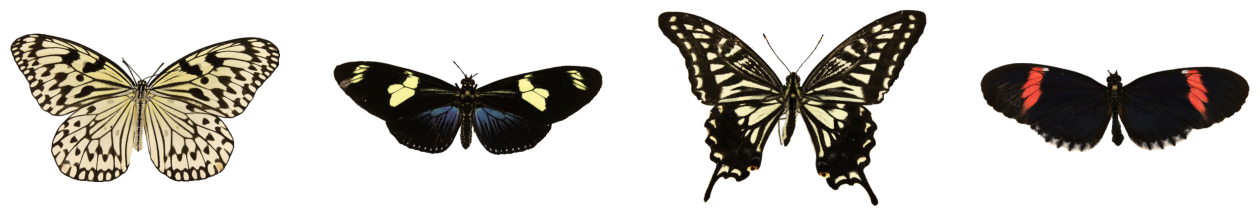

In [4]:
import matplotlib.pyplot as plt

fig,axs = plt.subplots(1, 4, figsize=(16, 4))
for i, image in enumerate(dataset[:4]["image"]):
  axs[i].imshow(image)
  axs[i].set_axis_off()
fig.show()

In [5]:
## PyTorch에 태우기 전에 이미지 전처리

from torchvision import transforms

preprocess = transforms.Compose(
    [
        transforms.Resize((config.image_size, config.image_size)),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.5], [0.5]),
    ]
)


In [6]:
## 앞에서 만든 preprocess 함수를 데이터 전체에 적용

def transform(examples):
  images = [preprocess(image.convert("RGB")) for image in examples["image"]]
  return {"images" : images}
dataset.set_transform(transform)
print(dataset)

Dataset({
    features: ['image_url', 'image_alt', 'id', 'name', 'scientific_name', 'gender', 'taxonomy', 'region', 'locality', 'date', 'usnm_no', 'guid', 'edan_url', 'source', 'stage', 'image', 'image_hash', 'sim_score'],
    num_rows: 1000
})


In [7]:
## 학습용 데이터 배치를 준비하는 과정

import torch

train_dataloader = torch.utils.data.DataLoader(dataset, batch_size=config.train_batch_size, shuffle=True)

In [8]:
## diffusion 모델에서 노이즈 제거를 담당하는 U-Net 기반 모델 구조 정의

from diffusers import UNet2DModel

model = UNet2DModel(
    sample_size = config.image_size,
    in_channels=3,
    out_channels=3,
    layers_per_block=2,
    block_out_channels=(128,128,256,256,512,512),
    down_block_types=( # Encoder 역할로 이미지의 해상도를 점점 낮추며 특징을 추출
        "DownBlock2D",
        "DownBlock2D",
        "DownBlock2D",
        "DownBlock2D",
        "AttnDownBlock2D",
        "DownBlock2D",
    ),
    up_block_types=( # Decoder 역할로 특징을 다시 이미지 크기로 복원해주는 블록
        "UpBlock2D",
        "AttnUpBlock2D",
        "UpBlock2D",
        "UpBlock2D",
        "UpBlock2D",
        "UpBlock2D",
    ),
)

In [ ]:
## 이미지 샘플 하나 뽑아서 준비

sample_image = dataset[0]["images"].unsqueeze(0)
print(sample_image.shape)

torch.Size([1, 3, 128, 128])


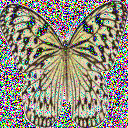

In [ ]:
## 정방향 과정(forward process)를 진행하며 이미지에 노이즈 추가

import torch
from PIL import Image
from diffusers import DDPMScheduler

noise_scheduler = DDPMScheduler(num_train_timesteps=1000)
noise = torch.randn(sample_image.shape)
timesteps = torch.LongTensor([50])
noisy_image = noise_scheduler.add_noise(sample_image, noise, timesteps)

Image.fromarray(((noisy_image.permute(0,2,3,1)+1.0)*127.5).type(torch.uint8).numpy()[0])


In [ ]:
## 노이즈를 예측하고, 실제 노이즈와 비교해 손실 계산

import torch.nn.functional as F

noise_pred = model(noisy_image, timesteps).sample
loss = F.mse_loss(noise_pred, noise)

In [ ]:
## 학습률을 cosine decay 방식으로 줄여가면서 초반에는 warmup으로 서서히 올려주는 스케줄러

from diffusers.optimization import get_cosine_schedule_with_warmup

optimizer = torch.optim.AdamW(model.parameters(), lr=config.learning_rate)
lr_scheduler = get_cosine_schedule_with_warmup(
    optimizer=optimizer,
    num_warmup_steps=config.lr_warmup_steps,
    num_training_steps=(len(train_dataloader) * config.num_epochs),
)

In [ ]:
from diffusers import DDPMPipeline
import math
import os

def make_grid(images, rows, cols):

  w, h = images[0].size
  grid = Image.new("RGB", size=(cols * w, rows * h))
  for i, image in enumerate(images):
    grid.paste(image, box=(i%cols *w, i // cols * h))
  return grid

def evaluate(config, epoch, pipeline):
  images = pipeline(
      batch_size=config.eval_batch_size,
      generator=torch.manual_seed(config.seed),
  ).images

  #Make a grid out of the images
  image_grid = make_grid(images, rows=4, cols=4)
  
  #save image
  test_dir = os.path.join(config.output_dir, "samples")
  os.makedirs(test_dir, exist_ok=True)
  image_grid.save(f"{test_dir}/{epoch:04d}.png")

In [ ]:
## DDPM 기반 Diffusion 모델을 Hugging Face accelerate로 학습하고
## 중간에 샘플 이미지를 출력하고 모델을 저장하는 학습 파이프라인
from accelerate import Accelerator
from huggingface_hub import HfFolder, Repository, whoami
from tqdm.auto import tqdm
from pathlib import Path
import os

def get_full_repo_name(model_id: str, organization: str= None, token:str =None):
  if token is None:
    token = HfFolder.get_token()
  if organization is None:
    username = whoami(token)["name"]
    return f"{username}/{model_id}"
  else:
    return f"{organization}/{model_id}"

def train_loop(config, model, noise_scheduler, optimizer, train_dataloader, lr_scheduler):
  accelerator = Accelerator(
      mixed_precision = config.mixed_precision,
      gradient_accumulation_steps=config.gradient_accumulation_steps,
      log_with="tensorboard",
      project_dir=os.path.join(config.output_dir, "logs"),
  )

  if accelerator.is_main_process:
    if config.push_to_hub:
      repo_name = get_full_repo_name(Path(config.output_dir).name)
      repo = Repository(config.output_dir, clone_from=repo_name)
    elif config.output_dir is not None:
      os.makedirs(config.output_dir, exist_ok=True)
    accelerator.init_trackers("train_example")

  model,optimizer, train_dataloader, lr_scheduler = accelerator.prepare(
      model, optimizer, train_dataloader, lr_scheduler)
  global_step = 0

  for epoch in range(config.num_epochs):
    progress_bar = tqdm(total=len(train_dataloader), disable=not accelerator.is_local_main_process)
    progress_bar.set_description(f"Epoch {epoch}")
    for step, batch in enumerate(train_dataloader):
      clean_images = batch["images"]
      noise = torch.randn(clean_images.shape).to(clean_images.device)
      bs = clean_images.shape[0]

      timesteps = torch.randint(
          0, noise_scheduler.config.num_train_timesteps, (bs,), device=clean_images.device
      ).long()

      noisy_images = noise_scheduler.add_noise(clean_images, noise, timesteps)
      with accelerator.accumulate(model):
        noise_pred = model(noisy_images, timesteps, return_dict=False)[0]
        loss = F.mse_loss(noise_pred, noise)
        accelerator.backward(loss)

        accelerator.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()
        lr_scheduler.step()
        optimizer.zero_grad()

      progress_bar.update(1)
      logs = {"loss": loss.detach().item(), "lr": lr_scheduler.get_last_lr()[0], "step":global_step}
      progress_bar.set_postfix(**logs)
      accelerator.log(logs, step=global_step)
      global_step+=1
  if accelerator.is_main_process:
    pipeline = DDPMPipeline(unet=accelerator.unwrap_model(model), scheduler=noise_scheduler)

    if (epoch+1)% config.save_image_epochs == 0 or epoch == config.num_epochs -1:
      evaluate(config, epoch, pipeline)

    if (epoch+1) % config.save_model_epochs == 0 or epoch == config.num_epochs -1:
      if config.push_to_hub:
        repo.push_to_hub(commit_message=f"Epoch {epoch}", blocking=True)
      else:
        pipeline.save_pretrained(config.output_dir)

In [23]:
import os

path = "ddpm-butterflies-128/logs/train_example"

# 만약 train_example이 파일이라면 삭제하고 디렉토리로 대체
if os.path.exists(path) and not os.path.isdir(path):
    os.remove(path)
    os.makedirs(path, exist_ok=True)

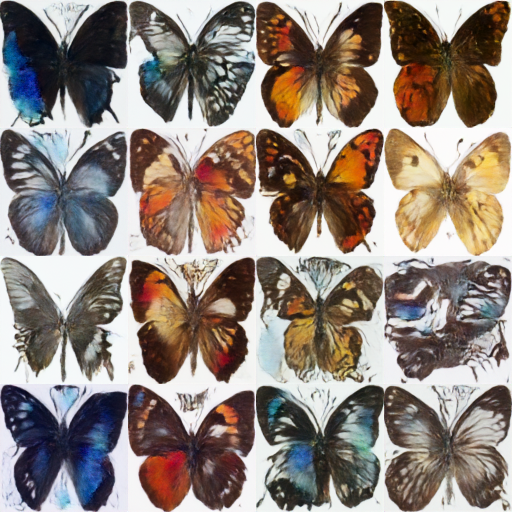

In [25]:
import glob

sample_images = sorted(glob.glob(f"{config.output_dir}/samples/*.png"))
Image.open(sample_images[-1])